# Geologic profiles with pygsf

*Doc started 2019-05-12*

*Current version: 2021-06-05*

*Last running version: 2021-06-05*

This notebook describes the calculation of topographic profiles. As input data we need a DEM and a profile. 

Figures are plotted via matplotlib:

In [1]:
%matplotlib inline

Data sets can be plotted with pprint:

In [2]:
from pprint import pprint

## 1-  Mount Alpi (Lucania, Southern Italy)

### DEM input

The source DEM is from publicly available Aster data and refers to the the Mt. Alpi zone (Lucania, Southern Italy):

In [3]:
source_data = "/home/mauro/Documents/projects/gsf/example_data/mt_alpi/malpi_aster_w4u3.tif"

We read the DEM info using a GDAL-based raster-band reader method:

In [4]:
from pygsf.io.rasters.gdal import try_read_raster_band
success, result = try_read_raster_band(raster_source=source_data)

In [5]:
print(success)

True


The raster was successfully read. The result is composed by a set of various infos:

In [6]:
geotransform, projection, band_params, data = result

In [7]:
for info in (geotransform, projection, band_params, data):
    print(f"info type: {type(info)}:\n\n{info}\n\n")

info type: <class 'pygsf.geometries.grids.geotransform.GeoTransform'>:

[ 5.80814583e+05  2.72759535e+01  0.00000000e+00  4.44429946e+06
  0.00000000e+00 -2.72759531e+01]


info type: <class 'str'>:

PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]


info type: <class 'dict'>:

{'dataType': 'Float32', 'unitType': '', 'stats': {'min': 0.0, 'max': 1829.0, 'mean': 1092.0445648248, 'std_dev': 302.5523744617}, 'noData': 3.4028234663852886e+38, 'numOver

The EPSG projection code is 32633.

The 'data' variable stores the raster values as a Numpy array.

Using this information, we can compose a *GeoArray* instance. It combines the geotransform, the EPSG code and one or more arrays (in this case, only one array) into a georeferenced object, that can be considered a *grid*:

In [8]:
from pygsf.georeferenced.rasters import *
geoarray = GeoArray(
    geotransform=geotransform,
    epsg_code=32633,
    arrays=[data]
)

We can plot this grid with a utility function:

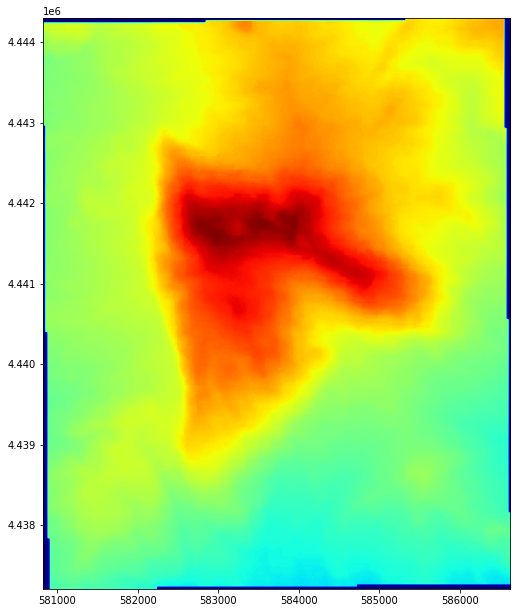

In [9]:
from pygsf.plots.rasters import plot_grid
fig = plot_grid(geoarray)

### Source profile

In order to create a topographic and geological profile, we need a trace. We read it from a line shapefile. 

In [10]:
from pygsf.io.vectors.gdal import try_read_line_shp_with_attr

src_profile_shapefile_pth = "/home/mauro/Documents/GeoDati/italia/macrozone/merid/regioni/basilicata/mt_alpi/livelli/profile_two.shp"
success, result = try_read_line_shp_with_attr(src_profile_shapefile_pth)

In [11]:
print(success)

True


The result is composed by a list of GeoLines-attributes pairs (stored as tuples). Each attribute set is applicable to all of the GeoLine list elements: remember that the source layer could store MultiLines. In the current case, we have just a single record, composed by a list with a single GeoLine2D and an empty attribute tuple.

In [12]:
print(result)

[([GeoLine2D with 5 points: (15.9606, 40.1331) ... (16.0100, 40.1058) with EPSG code 4326], ())]


In [13]:
[geoline], _ = result[0]

This *GeoLine2D* instance is a georeferenced line dataset, in this case containing just a line.

In [14]:
print(geoline.shape)

Line2D with 5 points: (15.9606, 40.1331) ... (16.0100, 40.1058)


It is a Line2D instance, that is made up by 5 points.

In [15]:
print(geoline.epsg_code)

4326


The spatial reference of the line profile is EPSG: 4326 (WGS1984), not the same as the raster DEM. 
Therefore a projection change is required before plotting against the DEM.

In [16]:
projected_geoline = geoline.project(
        dest_epsg_cd=32633
    )

DEBUG: extent is (15.960588941459031, 40.10582268253232, 16.009976747412004, 40.133110911523)
DEBUG: transformer_group is <TransformerGroup: best_available=True>
- transformers: 1
- unavailable_operations: 0
DEBUG: transformer_group.transformers[0] is proj=pipeline step proj=axisswap order=2,1 step proj=unitconvert xy_in=deg xy_out=rad step proj=utm zone=33 ellps=WGS84
DEBUG: x_array is [15.96058894 15.97514748 15.98684754 16.00302716 16.00997675]
DEBUG: y_array is [40.13311091 40.12518598 40.11950044 40.11226757 40.10582268]


In [17]:
print(projected_geoline)

GeoLine2D with 5 points: (581836.8042, 4442973.6024) ... (586078.8498, 4439991.3755) with EPSG code 32633


The projected georeferenced line is not *None*, but a GeoLine2D, so we got a valid result.

Now we plot the profile trace in the previous map.

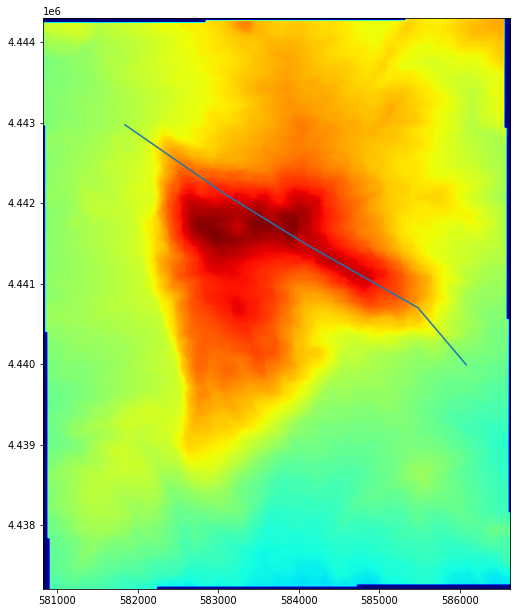

In [18]:
from pygsf.plots.vectors import plot_line

line = projected_geoline.shape
plot_line(fig, line)

### Initializing a line profiler

A line profiler allows to create geological profiles, by storing the source line, its EPSG code and the sampling distance.

In [19]:
from pygsf.profiles.profilers import LineProfiler

In [20]:
line_profiler = LineProfiler(
    src_line=line,
    densify_distance=10.0, # meters
    epsg_code=32633)

In [21]:
topographic_profile = line_profiler.profile_grid(
    geoarray=geoarray)

In [22]:
print(type(topographic_profile))

<class 'pygsf.geometries.shapes.space2d.XYArrayPair'>


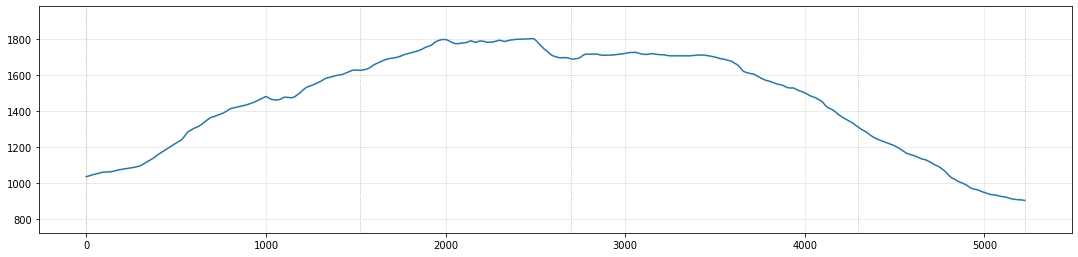

In [23]:
from pygsf.plots.profiles_matplotlib import plot
fig = plot(topographic_profile)

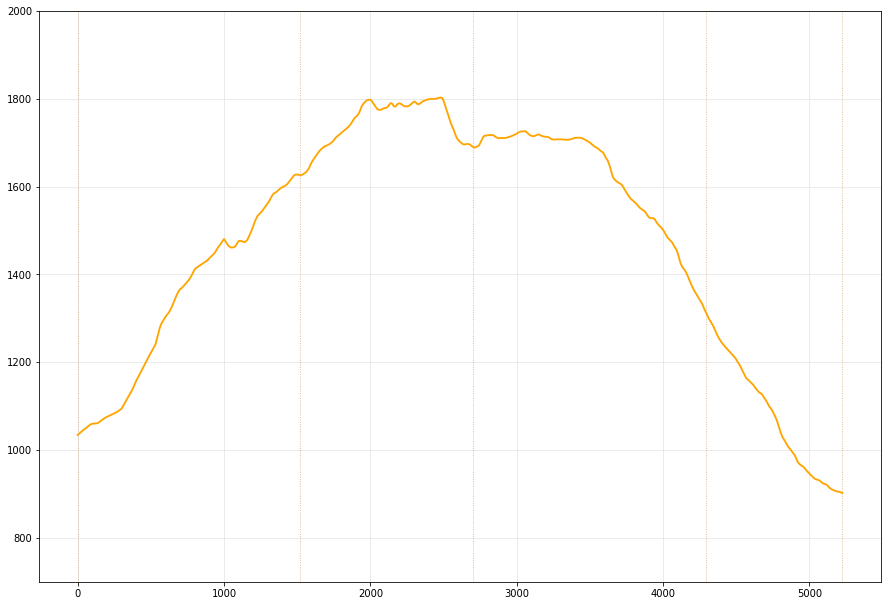

In [24]:
fig = plot(topographic_profile, color='orange', aspect=3, linewidth=1.85, z_min=700, z_max=2000)

In [25]:
topographic_profile.x_breaks()

array([   0.        , 1520.72806236, 2700.70025808, 4296.28180226,
       5225.06643905])

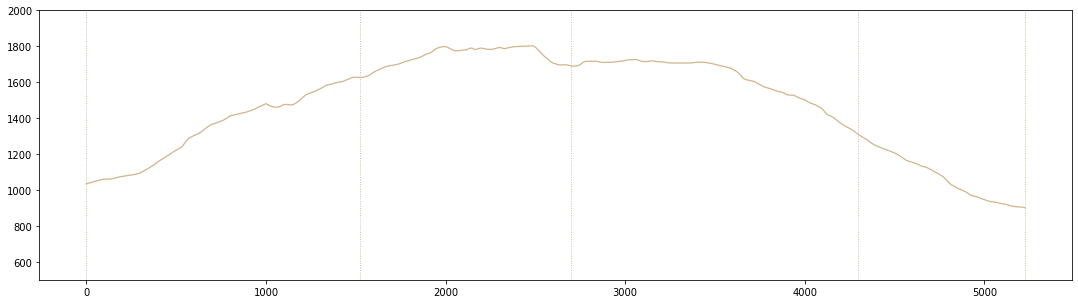

In [35]:
fig = plot(
    topographic_profile, 
    color='tan', 
    aspect=1, 
    linewidth=1.25, 
    z_min=500, 
    z_max=2000, 
    grid=False, 
    breaklines=True
)

### Initializing a geoprofile

A *geoprofile* can be considered a container for all topographic and geological data associated with a single geological profile. The simplest way to construct it is by initializing an empty geoprofile, and adding profile elements afterwards.

In [ ]:
from pygsf.profiles.geoprofiles import GeoProfile

geoprofile = GeoProfile()

### Using a segment profiler

To create the topographic and geologic datasets needed for populating a geoprofile, we need an operative element, that allows to extract georeferenced information from the topographic grids and the various geological elements. In *pygsf* we may use a *segment profiler*, implemented in the *SegmentProfiler* class.
The data extracted with the profiler are then added to the *geoprofile*. 

We create a *SegmentProfiler* instance. It is defined by a segment, a sample spacing (in the example below, each 5 meters along the profile) and an EPSG code (32633).

In [ ]:
from pygsf.profiles.profilers import SegmentProfiler

segment = Segment2D(start_pt=line.start_pt(), end_pt=line.end_pt())
segment_profiler = SegmentProfiler(
    segment2d=segment, 
    densify_distance= 5, # meters sampling distance along profile
    epsg_cd = 32633
)

In [ ]:
segment_profiler

Using a sampling distance of 5 meters along the profile, we create a straight profile composed by slightly more than 1,000 points. 

In [ ]:
segment_profiler.num_pts()

### Adding a topographic profile

With at least one grid (the geoarray) and a segment profiler we can create a topographic profile.

In [ ]:
topographic_profile = segment_profiler.profile_grid(geoarray)

In [ ]:
print("Type of 'topographic_profile': {}".format(type(topographic_profile)))

In [ ]:
print(topographic_profile)

The variable *topographic_profile* is an instance of the *XYArrayPair* class. 
Since we used just one grid as the input parameter for the *profile_grids* method, there is just a single topographic profile stored into the result list.

In [ ]:
from pygsf.plots.profiles import plot
plot(topographic_profile)

Now we can add the topographic profile to the geological profile:

In [ ]:
geoprofile.topo_profile = topographic_profile

and plot it:

In [ ]:
from pygsf.plots.profiles import plot

fig = plot(geoprofile)

We may note the text "Profile attitudes: None" above the plot. It means that no geological attitude is associated with the profile. We add them in the following steps.

### Plotting geological attitudes

A few geological attitudes in the proximity of the profiles are available in a point shapefile:

In [ ]:
attitudes_shape = "/home/mauro/Documents/projects/gsf/example_data/mt_alpi/attitudes.shp"

By using the *geopandas* module we can read the data. They are stored in a *geopandas.GeoDataFrame* instance.

In [ ]:
import geopandas

attitudes = geopandas.read_file(attitudes_shape)

attitudes

The data projection can be read with the *crs* geodataframe class attribute:

In [ ]:
attitudes.crs

The projection of the source dataset is UTM33, as are the DEM and the profile, so we do not need any reprojection.

To see the read data, we use the geopandas *plot* method:

In [ ]:
ax = attitudes.plot()

While the geopandas tools are handy for reading vectorial data, we need to read the source attitude data as a list of pygsf *GeorefAttitude* instances, in order to process them for the profile creation.

We use the quite verbose '*try_extract_flat_georeferenced_attitudes*' function from pygsf. 

In [ ]:
from pygsf.utils.profiles.geopandas import try_extract_flat_georeferenced_attitudes

success, result = try_extract_flat_georeferenced_attitudes(
    geodataframe = attitudes, 
    azim_fldnm = "dip_dir", 
    dip_ang_fldnm = "dip_ang"
)

Checking if we had success or not:

In [ ]:
print(success)

if not success:
    
    msg = result
    print(msg)
    
else:
    
    attitudes = result

Ok, if *true* we can go on and look at the data characteristics:

In [ ]:
print("Number of attitudes: {}".format(len(attitudes)))

There are eleven attitudes available. To look at their details, we just use *pprint*:

In [ ]:
pprint(attitudes)

A georeferenced attitude is defined by its *id* (a progressive counter, having not provided a field name to the '*try_extract_flat_georeferenced_attitudes function*'), *position* and *attitude*. 

We note that the attitude points are 2D. To plot them in a topographic profile, they need to present also the elevation information. To calculate it, we use the grid previously read within the *pygsf* *georef_attitudes_3d_from_grid* function.

In [ ]:
from pygsf.profiles.profilers import georef_attitudes_3d_from_grid

attitudes_3d = georef_attitudes_3d_from_grid(
        structural_data=attitudes,
        height_source=geoarray,
)

Let's have a look at the computed data:

In [ ]:
for att3d in attitudes_3d:
    print(att3d)

Now the attitudes have a 3D point. We can therefore proceed calculating the projections of the attitude on the section. 

In this example, we choose the 'nearest' mapping method for projecting the attitudes on the section: it projects the attitude normally to the profile.

In [ ]:
mapping_method = {}
mapping_method['method'] = 'nearest'

projected_attitudes = segment_profiler.map_georef_attitudes_to_section(
            attitudes_3d = attitudes_3d,
            mapping_method = mapping_method)

In [ ]:
for att in projected_attitudes:
    print("\n" + str(att))

Resulting profile attitudes are automatically sorted by their increasing distance along the profile (field 's'). The main fields are:
- *id*: identifier inherited from the georeferenced attitudes
- *s*: the distance of the projected attitude along the profile (may be negative or exceeed the profile length)
- *z*: the projected attitude elevation in the profile
- *slope_degr*: the resulting slope, in degrees 
- *down_sense*: describes whether the plane plunges to the right or to the left
- *dist*: the distance between the original attitude location and its projection (according to the chosen method) on the profile plane.

We assign the projected attitudes to the profile:

In [ ]:
geoprofile.profile_attitudes = projected_attitudes

The plot is possible with the usual *plot* method:

In [ ]:
fig = plot(geoprofile)

## 2 - Timpa San Lorenzo area (Calabria, Southern Italy) (in preparation)

Now we move around 35 km to the South-East of the Mt. Alpi are, and consider the Timpa San Lorenzo area, in Calabria, East of Mt. Pollino range.

The height source data is the TinItaly DEM.

In [ ]:
src_dem = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/tsl_tinitaly_w84u32.tif"
src_profile = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/profile.shp"

In [ ]:
from pygsf.io.rasters.gdal import try_read_raster_band
success, result = try_read_raster_band(raster_source=src_dem)

In [ ]:
print(success, result)

In [ ]:
geotransform, projection, band_params, data = result

In [ ]:
geoarray = GeoArray(
    geotransform=geotransform,
    epsg_code=32633,
    arrays=[data]    
)

In [ ]:
fig = plot_grid(geoarray)

In [ ]:
success, result = try_read_line_shp_with_attr(src_profile)

print(success)

In [ ]:
print(result)

In [ ]:
geolines = result[0][0]

In [ ]:
print(geolines)

In [ ]:
geoline = geolines[0]

In [ ]:
print(geoline.shape)

In [ ]:
line = geoline.shape

In [ ]:
plot_line(fig, line)

In [ ]:
from pygsf.profiles.geoprofiles import GeoProfileSet

geoprofiles = GeoProfileSet()

segment = Segment2D(start_pt=line.start_pt(), end_pt=line.end_pt())
base_profiler = SegmentProfiler(
    segment2d = segment, 
    densify_distance= 5,
    epsg_cd=32633
)

In [ ]:
base_profiler

In [ ]:
base_profiler.num_pts()

In [ ]:
from pygsf.profiles.profilers import ParallelProfilers

multiple_profilers = ParallelProfilers(
             base_profiler=base_profiler,
             num_profiles=15,
             offset=500,
             profs_arr="central"
)

In [ ]:
multiple_profilers

In [ ]:
topo_profiles = multiple_profilers.profile_grid(geoarray)

In [ ]:
print(type(topo_profiles))

They constitute a TopographicProfileSet instance.

In [ ]:
geoprofiles.topo_profiles_set = topo_profiles    

In [ ]:
fig = plot(geoprofiles)

### Line intersections

In [ ]:
import geopandas
faults_shape = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/faults.shp"
faults = geopandas.read_file(faults_shape)
faults

In [ ]:
type(faults)

In [ ]:
type(faults['geometry'][0])

In [ ]:
from pygsf.io.vectors.gdal import reading_line_shapefile

In [ ]:
success, answer = reading_line_shapefile(
    shp_path=faults_shape,
    flds=['fid', 'name'])

In [ ]:
print(success)

In [ ]:
results = answer

In [ ]:
pprint(results)

Here we check the type of the imported elements.

In [ ]:
line_types = set(map(lambda val: type(val[0]), results))
print(line_types)

They are all Line instances.

We filter the lines to be 'Timpa San Lorenzo thrust flat' elements.

In [ ]:
from operator import itemgetter
tsl_faults = [rec[0] for rec in results if rec[1][1] == 'Timpa San Lorenzo thrust flat']

In [ ]:
pprint(tsl_faults)

This is the set of line elements of the 'Timpa San Lorenzo thrust flat'.

## Test of intersection with single line profile

In [ ]:
base_profiler

In [ ]:
topo_profile = base_profiler.profile_grid(geoarray)

We construct a geological profile object, empty for now.

In [ ]:
geoprofile = GeoProfile()

Add the topographic profile to the geological profile and plot the former.

In [ ]:
geoprofile.topo_profile = topo_profile
fig = plot(geoprofile)

Now we try plotting the Timpa San Lorenzo flat intersection with the current profile.

In [ ]:
pprint(tsl_faults)

In [ ]:
line_intersections = base_profiler.intersect_lines(tsl_faults)

In [ ]:
pprint(line_intersections)

In [ ]:
profile_intersections = base_profiler.parse_profile_intersections(line_intersections)

In [ ]:
pprint(profile_intersections)

In [ ]:
geoprofile.lines_intersections = profile_intersections

In [ ]:
fig = plot(geoprofile)

## Analysing data with R

Help from:
 - https://thomas-cokelaer.info/blog/2012/04/how-to-call-r-plotting-function-from-python-using-rpy2/
 

To close non-inline graphics:

In [ ]:
try:
    r['dev.off']()
except:
    print("Already closed")

The data arrays are extracted from the topographic profile.

In [ ]:
s, z = topo_profile.x_arr(), topo_profile.y_arr()

Help from:
 - https://blog.jupyter.org/i-python-you-r-we-julia-baf064ca1fb6
 
 I Python, You R, We Julia
Matthias Bussonnier
Matthias Bussonnier
May 29, 2018 · 8 min read

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%Rpush s z

In [ ]:
%%R
plot(s, z, type="l", col="blue", ylim=c(500, 2000))
hist(z, col="orange")